In [ ]:
import json
import logging
from time import perf_counter
from typing import Literal, TypedDict

import numpy as np
from astropy.timeseries import LombScargle
from constants import DATA_DIR
from matplotlib import pyplot as plt
from tqdm import tqdm

from astrofit.model import Asteroid, Lightcurve, LightcurveBin
from astrofit.utils import (
    AsteroidLoader,
    LightcurveBinner,
    LightcurvePlotter,
    LightcurveSplitter,
)

In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger = logging.getLogger("freq")

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")

In [ ]:
asteroid_loader = AsteroidLoader(DATA_DIR)
lightcurve_binner = LightcurveBinner()
lightcurve_plotter = LightcurvePlotter()
lightcurve_splitter = LightcurveSplitter()

ASTEROIDS_FREQ_DATA_PATH = DATA_DIR / "asteroids_freq_data.json"

In [ ]:
MAX_PERIOD = 40

asteroids: dict[str, Asteroid] = {}
for asteroid_name in tqdm(asteroid_loader.available_asteroids):
    asteroid = asteroid_loader.load_asteroid(asteroid_name)
    if asteroid.period > MAX_PERIOD:
        continue

    asteroids[asteroid.name] = asteroid

print(f"Loaded {len(asteroids)} asteroids")

In [ ]:
class Config(TypedDict):
    max_hours_diff: float
    min_no_points: int
    top_k_bins: int
    buffer_bins: int
    select_bins_by: Literal["lightcurves", "points"]
    max_time_diff: float
    min_bin_size: int
    max_freq: float
    top_k_freqs: int
    nterms: int
    max_debug: bool  # If true, will print and plot everything


In [ ]:
def _split_lightcurves(asteroid: Asteroid, config: Config, debug: bool) -> list[Lightcurve]:
    max_hours_diff = config["max_hours_diff"]
    min_no_points = config["min_no_points"]

    if debug:
        logger.debug(
            f"Splitting lightcurves for {asteroid.name} with max_hours_diff={max_hours_diff} and min_no_points={min_no_points}"
        )

        logger.debug(f"Before splitting: {len(asteroid.lightcurves)} lightcurves")

    splitted = lightcurve_splitter.split_lightcurves(
        asteroid.lightcurves,
        max_hours_diff=max_hours_diff,
        min_no_points=min_no_points,
    )

    if debug:
        logger.debug(f"After splitting: {len(splitted)} lightcurves")

    return splitted


def _get_top_k_bins(lightcurves: list[Lightcurve], config: Config, debug: bool) -> list[LightcurveBin]:
    max_time_diff = config["max_time_diff"]
    min_bin_size = config["min_bin_size"]
    top_k_bins = config["top_k_bins"]
    buffer_bins = config["buffer_bins"]  # In case of too few frequencies for some of selected bins

    if debug:
        logger.debug(f"Getting top {top_k_bins} bins with max_time_diff={max_time_diff} and min_bin_size={min_bin_size}")

    bins = lightcurve_binner.bin_lightcurves(
        lightcurves,
        max_time_diff=max_time_diff,
        min_bin_size=min_bin_size,
    )

    if debug:
        logger.debug(f"After binning {len(bins)} bins available")

        if len(bins) < top_k_bins:
            logger.warning(f"Using {len(bins)} bins instead of {top_k_bins}")

    if config["select_bins_by"] == "lightcurves":
        return sorted(bins, reverse=True)[:top_k_bins + buffer_bins]

    elif config["select_bins_by"] == "points":
        return sorted(bins, key=lambda bin: bin.points_count, reverse=True)[:top_k_bins + buffer_bins]

    else:
        raise ValueError("Invalid value for select_bins_by")


def _get_top_k_freqs(lightcurve_bin: LightcurveBin, config: Config, debug: bool) -> tuple[list, list]:
    nterms = config["nterms"]
    top_k_freqs = config["top_k_freqs"]

    if debug:
        logger.debug(
            f"Getting top {top_k_freqs} frequencies with nterms={nterms} for "
            f"lightcurves={len(lightcurve_bin)} with total points={len(lightcurve_bin.times)}"
        )

    frequency, power = LombScargle(
        lightcurve_bin.times,
        lightcurve_bin.brightnesses,
        nterms=nterms,
    ).autopower(method="chi2", maximum_frequency=config["max_freq"])

    if debug and config["max_debug"]:
        plt.plot(frequency, power)

        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.title(f"Lomb-Scargle periodogram")
        plt.show()

    idx = np.argsort(power)[::-1][:top_k_freqs]
    top_k_freqs = frequency[idx]
    top_k_power = power[idx]

    return list(top_k_freqs), list(top_k_power)


def _has_anomalous_series(data: list[list[float]], magnitude_threshold: int = 2):
    if not data:
        return False

    medians = np.array([np.median(series) for series in data])
    overall_median = np.median(medians)
    ratios = medians / overall_median

    anomalous_series_exist = np.any(np.logical_or(ratios > 10**magnitude_threshold, ratios < 10 ** (-magnitude_threshold)))

    return anomalous_series_exist


def get_freq_features(
    asteroid: Asteroid,
    config: Config,
    as_list: bool = False,
    debug: bool = False,
) -> tuple[list, list] | tuple[np.ndarray, np.ndarray] | dict:
    splitted_lightcurves = _split_lightcurves(asteroid, config, debug)
    if _has_anomalous_series([lc.brightness_arr for lc in splitted_lightcurves]):
        if debug:
            logger.error("Anomalous series")
            logger.debug(f"{'-'*50}\n")

        return {"status": "failed", "reason": "anomalous series"}

    # Includes buffer bins
    top_k_bins = _get_top_k_bins(splitted_lightcurves, config, debug)

    if not top_k_bins:
        if debug:
            logger.error("No bins available")
            logger.debug(f"{'-'*50}\n")

        return {"status": "failed", "reason": "no bins"}

    top_k_bins_no = config["top_k_bins"]
    buffer_bins_no = config["buffer_bins"]

    freq_features = []
    power_features = []
    for ind, _bin in enumerate(top_k_bins):
        if len(freq_features) == top_k_bins_no:
            break

        if debug and ind >= top_k_bins_no:
            logger.debug(f"Using buffer bin {ind - top_k_bins_no + 1} / {buffer_bins_no}")


        if config["max_debug"]:
            lightcurve_plotter.plot_lightcurves(_bin)

        top_k_freqs, top_k_powers = _get_top_k_freqs(_bin, config, debug)
        if len(top_k_freqs) < config["top_k_freqs"]:
            if debug:
                logger.warning(f"Bin {ind} has only {len(top_k_freqs)} frequencies, skipping")

            continue

        freq_features.append(top_k_freqs)
        power_features.append(top_k_powers)

    if not freq_features:
        if debug:
            logger.error("No frequencies available")
            logger.debug(f"{'-'*50}\n")

        return {"status": "failed", "reason": "no frequencies"}

    if debug:
        logger.debug(f"{'-'*50}\n")

    if as_list:
        return freq_features, power_features

    return np.array(freq_features), np.array(power_features)

In [ ]:
config = Config(
    max_hours_diff=24,
    min_no_points=10,
    top_k_bins=4,
    buffer_bins=3,
    select_bins_by="points",
    max_time_diff=45,
    min_bin_size=1,
    max_freq=12,
    top_k_freqs=50,
    nterms=3,
    max_debug=True,
)

In [ ]:
asteroid = asteroids["Ceres"]

In [ ]:
print(f"Target frequency: {24 / asteroid.period}")

In [ ]:
get_freq_features(asteroid, config, debug=True)

In [ ]:
config['max_debug'] = False

In [ ]:
assert not config["max_debug"], "Disable max_debug before running for all asteroids!!!"

failed_cnt = 0
asteroids_data = {}
for asteroid_name, asteroid in tqdm(asteroids.items()):
    start = perf_counter()
    features = get_freq_features(asteroid, config, as_list=True, debug=False)
    processing_time = perf_counter() - start

    asteroids_data[asteroid_name] = {
        "is_failed": False,
        "reason": None,
        "period": asteroid.period,
        "processing_time": processing_time,
        "freq_features": [],
        "pow_features": [],
    }
    if isinstance(features, dict):
        failed_cnt += 1
        asteroids_data[asteroid_name]["is_failed"] = True
        asteroids_data[asteroid_name]["reason"] = features["reason"]
        continue

    freq_features, pow_features = features

    assert len(freq_features) in (1, 2, 3, 4), f"Invalid number of sequences: {len(freq_features)} for {asteroid_name}"
    for freq in freq_features:
        assert len(freq) == 50, f"Invalid number of frequencies: {len(freq)} for {asteroid_name}"

    asteroids_data[asteroid_name]["freq_features"] = freq_features
    asteroids_data[asteroid_name]["pow_features"] = pow_features

print(f"Failed asteroids: {failed_cnt} ({failed_cnt / len(asteroids) * 100:.2f}%)")
print(f"{'-'*50}")

dump_data = {
    "config": config,
    "asteroids": asteroids_data,
}

with open(ASTEROIDS_FREQ_DATA_PATH, "w") as f:
    json.dump(dump_data, f, indent=4)

In [ ]:
asteroid = asteroids["1177 T-3"]
asteroid

In [ ]:
24 / 32.12

In [ ]:
config['max_debug'] = True

In [ ]:
freqs, pows = get_freq_features(asteroid, config, as_list=True, debug=True)

In [ ]:
failed_asteroids = filter(lambda x: x[1]["is_failed"], asteroids_data.items())


In [ ]:
from collections import Counter

In [ ]:
reasons = Counter([failed_asteroid["reason"] for _, failed_asteroid in failed_asteroids])
print(reasons)

In [21]:
with open(ASTEROIDS_FREQ_DATA_PATH, "r") as f:
    data = json.load(f)

In [22]:
asteroids_data = data["asteroids"]

In [43]:
diffs = {}
for asteroid_name, asteroid_data in asteroids_data.items():
    if asteroid_data["is_failed"]:
        continue

    target_freq = 24 / asteroid_data["period"]
    freqs = np.array(asteroid_data["freq_features"])

    top_k_freqs = freqs[:, :20] - target_freq
    min_diff = np.min(np.abs(top_k_freqs))

    diffs[asteroid_name] = min_diff

In [46]:
percentiles = np.percentile(list(diffs.values()), [0, 5, 25, 50, 75, 95, 100])
percentiles

array([2.03907503e-06, 5.19644718e-04, 4.84179518e-03, 2.03616162e-02,
       6.29651520e-02, 4.03767720e-01, 7.92297193e+00])

In [49]:
selected_asteroids = {name: data for name, data in asteroids_data.items() if name in diffs and diffs[name] > percentiles[-2]}
len(selected_asteroids)

134

In [50]:
from random import choice

2024-07-01 20:10:01,043 - freq - DEBUG - Splitting lightcurves for Guernica with max_hours_diff=24 and min_no_points=10
2024-07-01 20:10:01,044 - freq - DEBUG - Before splitting: 1 lightcurves
2024-07-01 20:10:01,045 - freq - DEBUG - After splitting: 3 lightcurves
2024-07-01 20:10:01,045 - freq - DEBUG - Getting top 4 bins with max_time_diff=45 and min_bin_size=1
2024-07-01 20:10:01,046 - freq - DEBUG - After binning 2 bins available
2024-07-01 20:10:01,046 - freq - WARNING - Using 2 bins instead of 4


Guernica


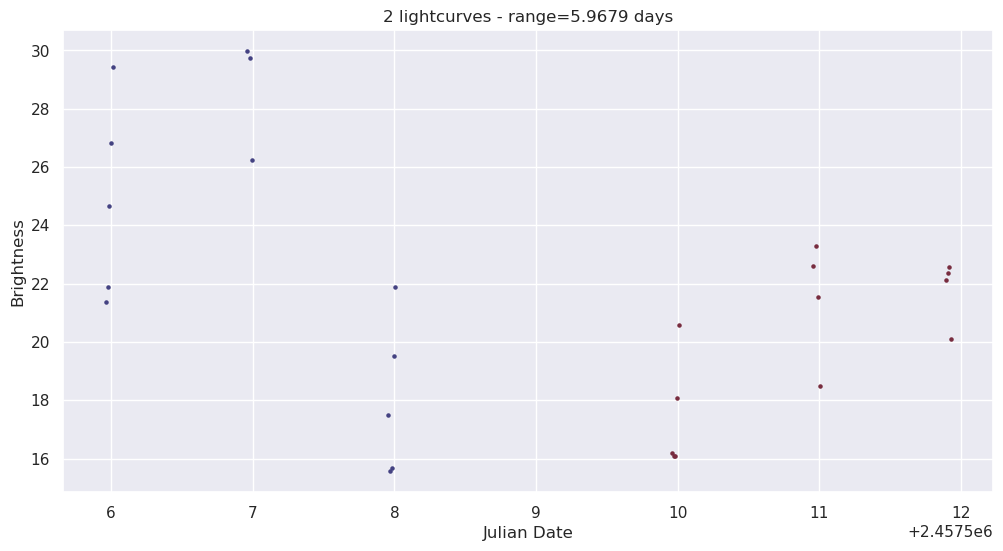

2024-07-01 20:10:01,200 - freq - DEBUG - Getting top 50 frequencies with nterms=3 for lightcurves=2 with total points=26


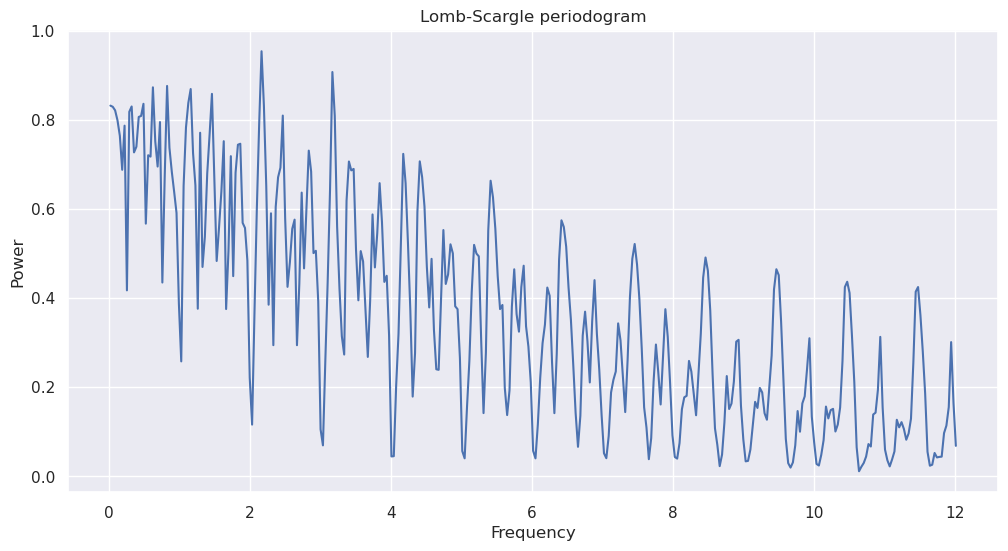

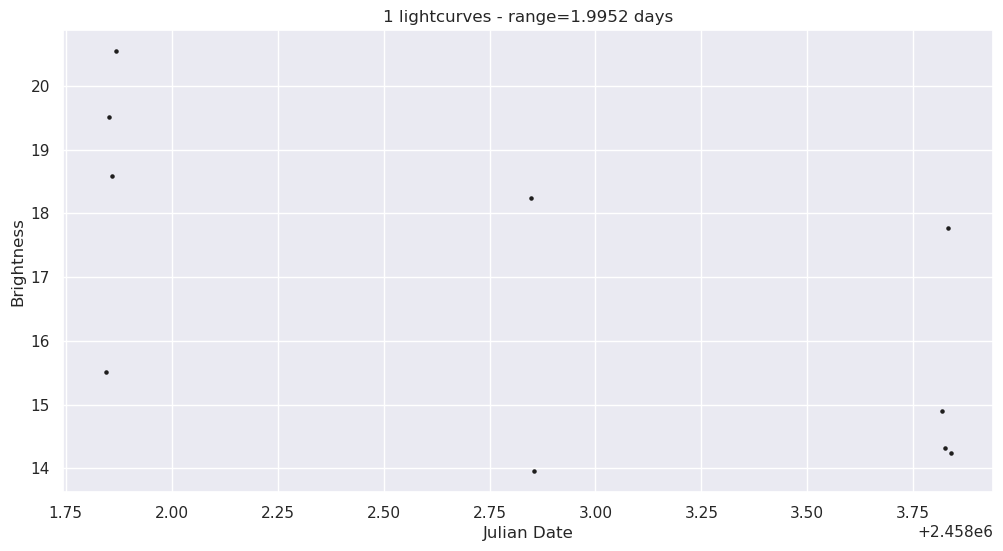

2024-07-01 20:10:01,509 - freq - DEBUG - Getting top 50 frequencies with nterms=3 for lightcurves=1 with total points=10


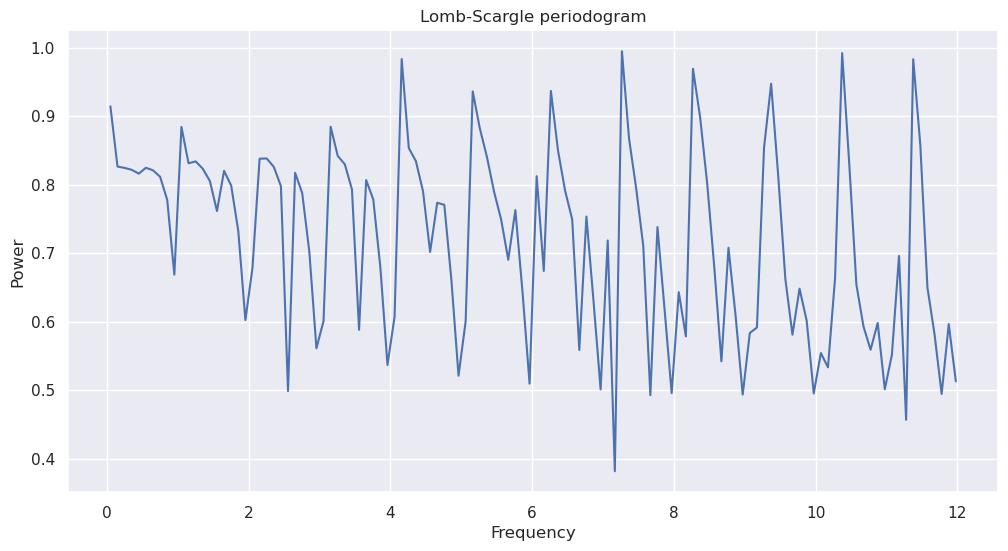

2024-07-01 20:10:01,651 - freq - DEBUG - --------------------------------------------------



(array([[ 2.1615535 ,  3.16692723,  0.82105521,  0.61998046,  1.15617978,
          1.4577919 ,  1.12266732,  0.48593063,  0.01675623,  2.19506596,
          0.31836835,  0.05026869,  0.08378114,  0.28485589,  2.46316562,
          3.20043968,  0.45241818,  0.41890572,  0.1172936 ,  0.72051783,
          2.12804105,  0.21783097,  1.08915487,  1.29022961,  1.42427944,
          0.15080606,  1.62535418,  0.65349292,  1.85994139,  1.82642893,
          0.38539326,  0.85456766,  2.83180265,  0.3518808 ,  1.18969224,
          4.17230095,  0.55295555,  1.72589156,  0.586468  ,  4.40688815,
          3.40151443,  0.68700538,  2.42965316,  3.46853934,  0.18431852,
          3.43502689,  2.86531511,  0.88808012,  1.79291647,  1.39076698],
        [ 7.26733259, 10.37474376,  4.15992141, 11.37713447,  8.26972329,
          9.37235306,  6.26494189,  5.16231211,  0.05011954,  8.36996236,
          3.15753071,  1.05251024,  5.26255118,  7.36757166, 11.47737354,
          9.27211399,  4.26016048,  6

In [51]:
ast = choice(list(selected_asteroids.keys()))
print(ast)

get_freq_features(asteroids[ast], config, debug=True)